In [1]:
# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
np.random.seed(3301)
import pandas as pd
# Para crear el arbol de decisión 
from sklearn.tree import DecisionTreeClassifier 
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
from sklearn import tree
import datetime
from langdetect import detect



In [2]:
# Se cargan los datos. 
df=pd.read_csv('mbsa.csv',  delimiter=",", header=0)
# Cantidad de datos y número de variables
df.shape

(19344048, 3)

In [3]:
# Mostrar los datos
df.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [4]:

df.describe()

,Date,text,Sentiment
count,19344048,19344032,18452904
unique,1917,14876178,3
top,2018-08-03,$EPAZ's Bitcoin Sharing &amp; Blockchain Socia...,Negative
freq,995986,891106,9729297


In [5]:
# Toma de muestra de los datos
dft = df.sample(50000)

In [6]:
# Se estandariza la informacion

# funcion para asignar idioma
def getLanguage (row):
    try:
        return detect(row['text'])
    except:
        return ''

# filtrar por idoma idioma
dft['language']=dft.apply (lambda row: getLanguage(row), axis=1)
dft=dft[dft['language']=='en']

# Transformar texto a valor numerico
dft['Sentiment'].replace({'Positive':1, 'Negative':0}, inplace = True)
dft=dft[dft['Sentiment'].isin([1,0])]


In [7]:
dft.head()

,Date,text,Sentiment,language
16020949,2019-09-28,$btc #bitcoin | 1H\n\n#IchiEMAPrime Setup. We'...,0.0,en
1282301,2019-05-12,What a beautiful sight to see. I’m actually em...,0.0,en
5807147,2019-05-30,"Principal and Lead, BPO Advisory Practice - Lo...",0.0,en
12787632,2019-08-12,"Price Update: 1 #Bitcoin = $11,548.63 📈 \n\n#c...",0.0,en
13680025,2019-08-25,Get #Bitcoin in your wallet every day even whe...,0.0,en


In [8]:
def is_date(dates):
    result = []
    for date in dates:
        try: 
            datetime.datetime.strptime(date, '%Y-%m-%d')
            result.append(date)
        except ValueError:
            a=''
    return result

validDates = is_date(dft['Date'])

dft=dft[dft['Date'].isin(validDates)]

In [9]:
dft.shape

(34002, 4)

In [10]:
pd.value_counts(dft['Sentiment'])

0.0    17352
1.0    16650
Name: Sentiment, dtype: int64

In [11]:
dft.head()

,Date,text,Sentiment,language
16020949,2019-09-28,$btc #bitcoin | 1H\n\n#IchiEMAPrime Setup. We'...,0.0,en
1282301,2019-05-12,What a beautiful sight to see. I’m actually em...,0.0,en
5807147,2019-05-30,"Principal and Lead, BPO Advisory Practice - Lo...",0.0,en
12787632,2019-08-12,"Price Update: 1 #Bitcoin = $11,548.63 📈 \n\n#c...",0.0,en
13680025,2019-08-25,Get #Bitcoin in your wallet every day even whe...,0.0,en


In [12]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def labelWeekDay (row):
    return datetime.datetime.strptime(row['Date'], '%Y-%m-%d').weekday()
     
dft['weekday_label']=dft.apply (lambda row: labelWeekDay(row), axis=1)


In [13]:
# Mostrar los datos
dft.head()

,Date,text,Sentiment,language,weekday_label
16020949,2019-09-28,$btc #bitcoin | 1H\n\n#IchiEMAPrime Setup. We'...,0.0,en,5
1282301,2019-05-12,What a beautiful sight to see. I’m actually em...,0.0,en,6
5807147,2019-05-30,"Principal and Lead, BPO Advisory Practice - Lo...",0.0,en,3
12787632,2019-08-12,"Price Update: 1 #Bitcoin = $11,548.63 📈 \n\n#c...",0.0,en,0
13680025,2019-08-25,Get #Bitcoin in your wallet every day even whe...,0.0,en,6


In [14]:
def labelKeyWord(row,word):
    return row['text'].count(word)

#Seleccion de palabras clave
keyWords=['bitcoin','$','buy','get','use','blockchain','market','crypto','time','price','wallet','transact','exchange', 'cryptocurr']

for word in keyWords:
    dft[word]=dft.apply (lambda row: labelKeyWord(row, word), axis=1)

In [15]:
dft = dft.drop(['text', 'Date', 'language'], axis=1)
dft.head()

,Sentiment,weekday_label,bitcoin,$,buy,get,use,blockchain,market,crypto,time,price,wallet,transact,exchange,cryptocurr
16020949,0.0,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1282301,0.0,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0
5807147,0.0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12787632,0.0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,1
13680025,0.0,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [16]:
# Se selecciona la variable objetivo, en este caso "Sentiment".
Y = dft['Sentiment']
# Del conjunto de datos se elimina la variable "Sentiment"
X = dft.drop(['Sentiment'], axis=1)

In [17]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [18]:
# Crear el objeto de arbol de decisión.
arbol = DecisionTreeClassifier(criterion='entropy', random_state=0)

In [19]:
# Entrenar el modelo de arbol de decisión con los datos de entrenamiento
arbol = arbol.fit(X_train,Y_train)

In [20]:
# Determinamos las predicciones del modelo sobre el conjunto test.
y_pred = arbol.predict(X_test)

In [21]:
# Se genera la matriz de confusión
confusion_matrix(Y_test, y_pred)

array([[2078, 1354],
       [1637, 1732]])

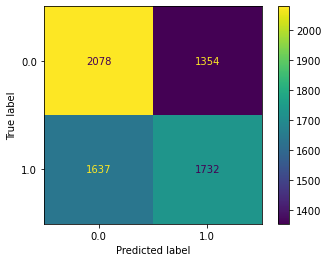

In [22]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol, X_test, Y_test)  
plt.show()  

In [23]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred)))
print("Precisión: {}".format(precision_score(Y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred)))

Exactitud: 0.56
Recall: 0.5140991392104483
Precisión: 0.5612443292287751
Puntuación F1: 0.5366382649109218


In [24]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.61      0.58      3432
         1.0       0.56      0.51      0.54      3369

    accuracy                           0.56      6801
   macro avg       0.56      0.56      0.56      6801
weighted avg       0.56      0.56      0.56      6801



In [25]:
importancia= arbol.feature_importances_
importancia

array([0.14481397, 0.06899724, 0.18557049, 0.03487826, 0.04865307,
       0.0571889 , 0.06327325, 0.05751715, 0.11025912, 0.03376872,
       0.05611111, 0.03199143, 0.0181532 , 0.04069347, 0.04813062])

In [26]:
# Vemos cual el las importancia de las variables
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,$,0.185570
1,weekday_label,0.144814
2,crypto,0.110259
3,bitcoin,0.068997
4,blockchain,0.063273
5,market,0.057517
6,use,0.057189
7,price,0.056111
8,get,0.048653
9,cryptocurr,0.048131


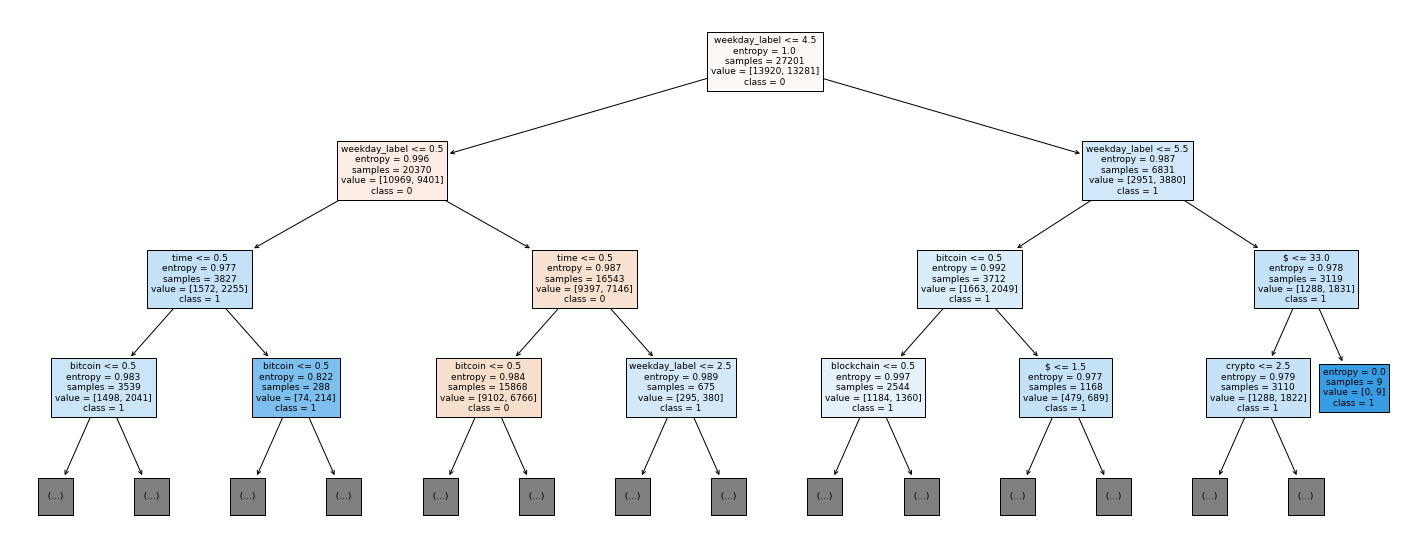

In [27]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol, max_depth=3, feature_names=X.columns, class_names=["0", "1"], filled=True, fontsize=9)

In [28]:
# Dividimos el conjunto de entrenamiento en dos: una para la construcción del modelo (sería el nuevo conjunto de 
# entrenamiento) y otro para la validación, el cuál será utilizado para determinar el rendimiento del modelo con una
# combinación específica de hiperparámetros.
X_trainval, X_val, Y_trainval, Y_val = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 0)

In [29]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

In [30]:
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20],'min_samples_split':[2, 3, 4, 5]}

In [31]:
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

In [32]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20],
                         'min_samples_split': [2, 3, 4, 5]})

In [33]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}

In [34]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(X_train)
y_pred_test = arbol_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))
print("Precisión sobre test: {}".format(precision_score(Y_test,y_pred_test)))


Exactitud sobre entrenamiento: 0.58
Exactitud sobre test: 0.58
Precisión sobre test: 0.5927601809954751


In [35]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.57      0.69      0.62      3432
         1.0       0.59      0.47      0.52      3369

    accuracy                           0.58      6801
   macro avg       0.58      0.58      0.57      6801
weighted avg       0.58      0.58      0.57      6801



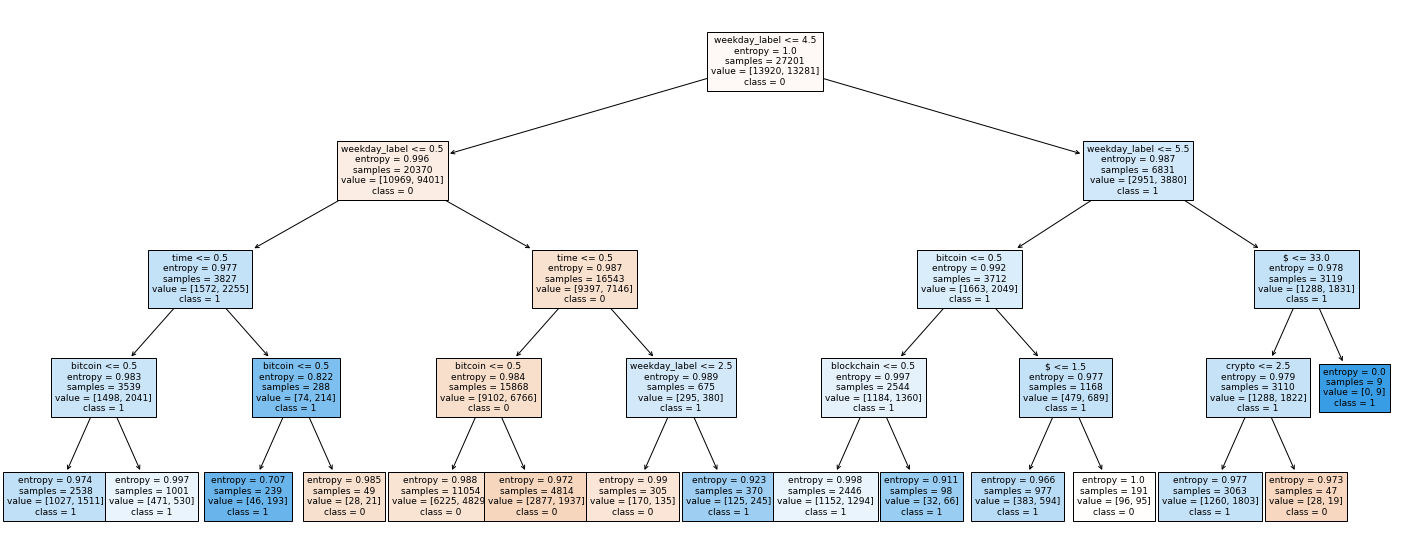

In [36]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol_final, max_depth=4, feature_names=X_train.columns, class_names=["0", "1"], filled=True, fontsize=9)